In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import pickle
import warnings
import pandas as pd
import time
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, make_scorer
from drive.MyDrive.BE_Project_Data.utility_functions import model_evaluate, preprocess_data

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from xgboost import XGBClassifier
from mlxtend.classifier import StackingCVClassifier

/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)


In [3]:
warnings.filterwarnings("ignore")
pd.set_option("display.max_colwidth", 200)
sns.set_context("talk", font_scale=1)

In [4]:
data = pd.read_pickle("drive/MyDrive/BE_Project_Data/processed_training_data.pkl")
val_data = pd.read_pickle("drive/MyDrive/BE_Project_Data/processed_validation_data.pkl")

In [5]:
data.head()

,Tweet,Depressive
0,severely depressed summer seriously thought haveis not depression anymore surpassed first holder new worse mental illness,1
1,like wake panic knowing thing get done today already dreading moment foot touch ground mentalhealthissues anxienty depression,1
2,bpd anxiety depression,1
3,depression make forget trying not gain weight,1
4,really survive depression,1


In [6]:
data.tail()

,Tweet,Depressive
1081861,woke no school best feeling ever,0
1081862,thewdb com cool hear old walt interview,0
1081863,ready mojo makeover ask detail,0
1081864,happy th birthday boo time tupac amaru shakur,0
1081865,happy charitytuesday,0


In [7]:
X_train, X_test, y_train, y_test = train_test_split(data["Tweet"], data["Depressive"]
                                                    , test_size=.10
                                                    , stratify=data["Depressive"]
                                                    , random_state=23)

# **Multinomial Naive Bayes (Hyperparameter Tuning)**

In [8]:
mnb_classifier = Pipeline([('vect', CountVectorizer()),
                      ('clf', MultinomialNB())])

In [16]:
mnb_parameters = {
                    'vect__ngram_range': [(1, 2), (1,3)],
                    'vect__max_features': [200000, 500000],
                    'clf__alpha': (1.0, 2.0, 5.0)
            }

In [17]:
start = time.time()
mnb_gs_clf = GridSearchCV(mnb_classifier, mnb_parameters, scoring='recall', cv=5, verbose=3)
mnb_gs_clf.fit(X_train, y_train)
mnb_time = (time.time()-start) / 60
print("MNB model training time (mins) : ", mnb_time)

best_parameters = mnb_gs_clf.best_estimator_.get_params()

for param_name in sorted(mnb_parameters.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))

Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV] clf__alpha=1.0, vect__max_features=200000, vect__ngram_range=(1, 2) 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  clf__alpha=1.0, vect__max_features=200000, vect__ngram_range=(1, 2), score=0.829, total=  32.3s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   32.3s remaining:    0.0s


[CV] clf__alpha=1.0, vect__max_features=200000, vect__ngram_range=(1, 2) 
[CV]  clf__alpha=1.0, vect__max_features=200000, vect__ngram_range=(1, 2), score=0.826, total=  31.8s


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  1.1min remaining:    0.0s


[CV] clf__alpha=1.0, vect__max_features=200000, vect__ngram_range=(1, 2) 
[CV]  clf__alpha=1.0, vect__max_features=200000, vect__ngram_range=(1, 2), score=0.827, total=  32.0s
[CV] clf__alpha=1.0, vect__max_features=200000, vect__ngram_range=(1, 2) 
[CV]  clf__alpha=1.0, vect__max_features=200000, vect__ngram_range=(1, 2), score=0.828, total=  31.8s
[CV] clf__alpha=1.0, vect__max_features=200000, vect__ngram_range=(1, 2) 
[CV]  clf__alpha=1.0, vect__max_features=200000, vect__ngram_range=(1, 2), score=0.827, total=  31.7s
[CV] clf__alpha=1.0, vect__max_features=200000, vect__ngram_range=(1, 3) 
[CV]  clf__alpha=1.0, vect__max_features=200000, vect__ngram_range=(1, 3), score=0.827, total=  58.4s
[CV] clf__alpha=1.0, vect__max_features=200000, vect__ngram_range=(1, 3) 
[CV]  clf__alpha=1.0, vect__max_features=200000, vect__ngram_range=(1, 3), score=0.823, total=  58.4s
[CV] clf__alpha=1.0, vect__max_features=200000, vect__ngram_range=(1, 3) 
[CV]  clf__alpha=1.0, vect__max_features=20000

[Parallel(n_jobs=1)]: Done  60 out of  60 | elapsed: 45.6min finished


MNB model training time (mins) :  46.18744607369105
	clf__alpha: 1.0
	vect__max_features: 200000
	vect__ngram_range: (1, 2)


              precision    recall  f1-score   support

           0       0.96      0.96      0.96     87616
           1       0.83      0.83      0.83     20571

    accuracy                           0.94    108187
   macro avg       0.90      0.90      0.90    108187
weighted avg       0.94      0.94      0.94    108187



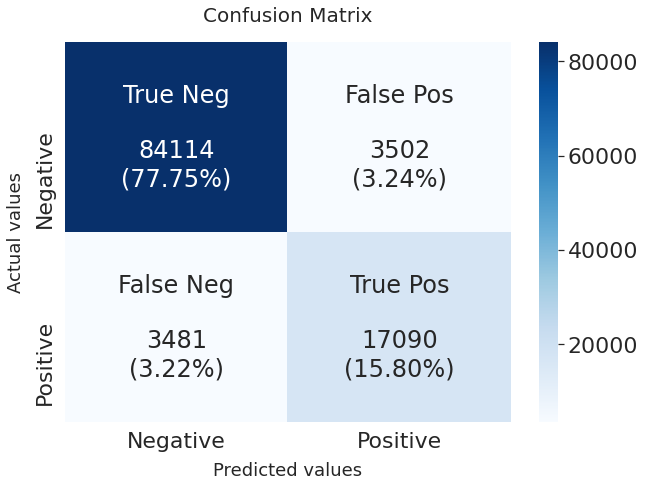

In [18]:
mnb_gs_clf_pred = pd.Series(model_evaluate(mnb_gs_clf, X_test, y_test))

In [19]:
val_x = val_data.loc[:, ["Tweet"]]
val_y = val_data.loc[:, ["Depressive"]]

In [20]:
val_x.head()

,Tweet
0,today selfcare beauty amp laugh kung fu panda wellness joy laughter selfcare therapist philadelphia
1,get spend new year home alone lonely
2,depressed lonely stuck deep never ending hole sad
3,response someone saying dealing terrible person
4,apparently get free pas mentioning free badge day


In [21]:
val_y.head()

,Depressive
0,0
1,1
2,1
3,0
4,0


              precision    recall  f1-score   support

           0       0.82      0.71      0.76      2357
           1       0.41      0.56      0.47       843

    accuracy                           0.67      3200
   macro avg       0.61      0.63      0.61      3200
weighted avg       0.71      0.67      0.68      3200



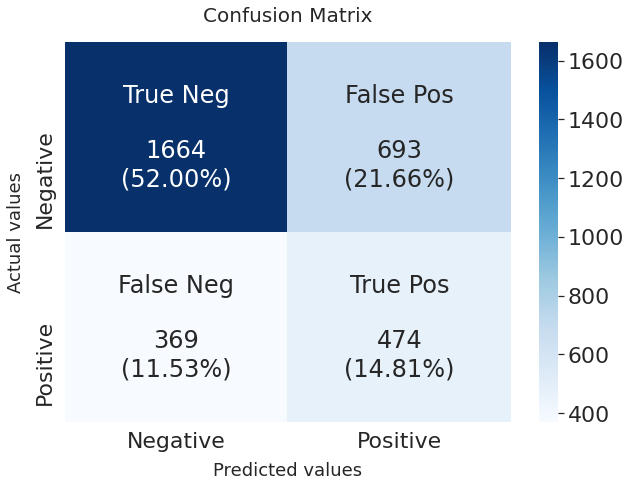

In [22]:
mnb_pred_val = pd.Series(model_evaluate(mnb_gs_clf, val_x.Tweet, val_y))

## **XGBoost (Hyperpameter Tuning)**

In [23]:
vectorizer = CountVectorizer(ngram_range=(1, 2), max_features=200000)

In [24]:
vectorizer.fit(X_train)

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                lowercase=True, max_df=1.0, max_features=200000, min_df=1,
                ngram_range=(1, 2), preprocessor=None, stop_words=None,
                strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, vocabulary=None)

In [25]:
X_train_vec = vectorizer.transform(X_train)
X_test_vec = vectorizer.transform(X_test)

In [26]:
print(X_train_vec.shape)
print(X_test_vec.shape)

(973679, 200000)
(108187, 200000)


In [27]:
xgb_clf = XGBClassifier()

xgb_parameters =   {
    'n_estimators': [100, 200],
    'max_depth': [6, 8, 10],
    'gamma': [0.1, 0.3, 0.5]
  }

In [28]:
start = time.time()
xgb_gs_clf = GridSearchCV(xgb_clf, param_grid=xgb_parameters, cv=3, scoring='f1_macro', verbose=3)
xgb_gs_clf.fit(X_train_vec, y_train)
xgb_time = (time.time()-start) / 60
print("XGB model training time (mins) : ", xgb_time)

Fitting 3 folds for each of 18 candidates, totalling 54 fits
[CV] gamma=0.1, max_depth=6, n_estimators=100 ........................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  gamma=0.1, max_depth=6, n_estimators=100, score=0.920, total= 2.1min
[CV] gamma=0.1, max_depth=6, n_estimators=100 ........................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  2.1min remaining:    0.0s


[CV]  gamma=0.1, max_depth=6, n_estimators=100, score=0.920, total= 2.0min
[CV] gamma=0.1, max_depth=6, n_estimators=100 ........................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  4.1min remaining:    0.0s


[CV]  gamma=0.1, max_depth=6, n_estimators=100, score=0.921, total= 2.0min
[CV] gamma=0.1, max_depth=6, n_estimators=200 ........................
[CV]  gamma=0.1, max_depth=6, n_estimators=200, score=0.923, total= 3.9min
[CV] gamma=0.1, max_depth=6, n_estimators=200 ........................
[CV]  gamma=0.1, max_depth=6, n_estimators=200, score=0.923, total= 4.0min
[CV] gamma=0.1, max_depth=6, n_estimators=200 ........................
[CV]  gamma=0.1, max_depth=6, n_estimators=200, score=0.924, total= 3.9min
[CV] gamma=0.1, max_depth=8, n_estimators=100 ........................
[CV]  gamma=0.1, max_depth=8, n_estimators=100, score=0.921, total= 2.7min
[CV] gamma=0.1, max_depth=8, n_estimators=100 ........................
[CV]  gamma=0.1, max_depth=8, n_estimators=100, score=0.922, total= 2.6min
[CV] gamma=0.1, max_depth=8, n_estimators=100 ........................
[CV]  gamma=0.1, max_depth=8, n_estimators=100, score=0.922, total= 2.7min
[CV] gamma=0.1, max_depth=8, n_estimators=200 ...

[Parallel(n_jobs=1)]: Done  54 out of  54 | elapsed: 218.7min finished


XGB model training time (mins) :  228.32319192488987


KeyError: ignored

In [29]:
best_parameters = xgb_gs_clf.best_estimator_.get_params()

for param_name in sorted(xgb_parameters.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))

	gamma: 0.1
	max_depth: 10
	n_estimators: 200


              precision    recall  f1-score   support

           0       0.95      1.00      0.97     87616
           1       0.99      0.78      0.88     20571

    accuracy                           0.96    108187
   macro avg       0.97      0.89      0.93    108187
weighted avg       0.96      0.96      0.96    108187



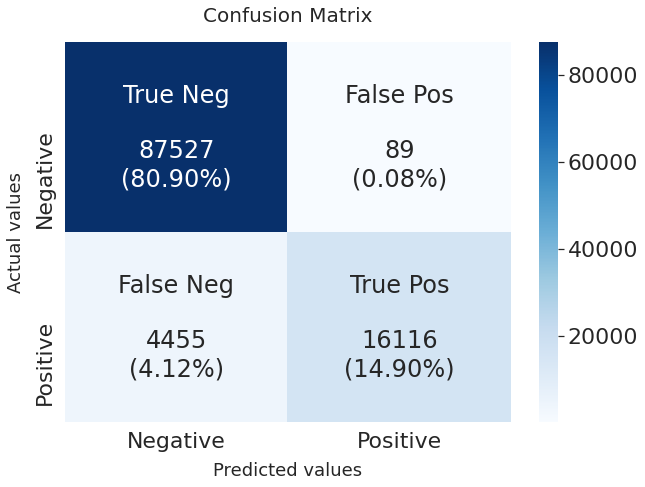

In [31]:
xgb_gs_clf_pred = pd.Series(model_evaluate(xgb_gs_clf, X_test_vec, y_test))

In [38]:
val_x_xgb = vectorizer.transform(val_x.Tweet)
val_x_xgb.shape

(3200, 200000)

              precision    recall  f1-score   support

           0       0.75      0.96      0.84      2357
           1       0.50      0.11      0.18       843

    accuracy                           0.74      3200
   macro avg       0.62      0.54      0.51      3200
weighted avg       0.68      0.74      0.67      3200



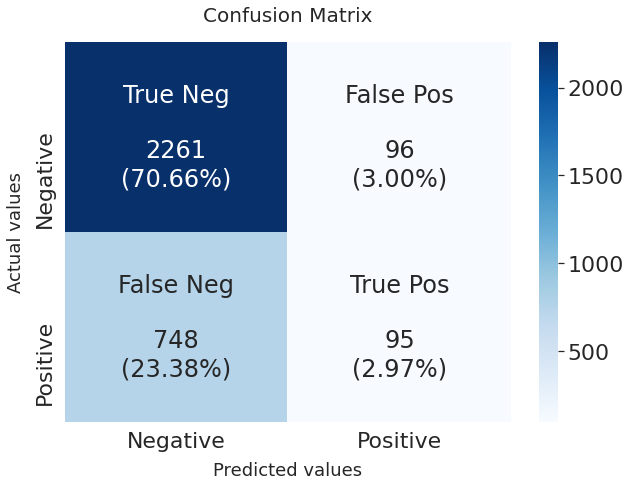

In [40]:
xgb_pred_val = pd.Series(model_evaluate(xgb_gs_clf, val_x_xgb, val_y))